# import packages and define stimulus protocols

In [51]:
# using MAT
using ProgressMeter
using Printf
using MultivariateStats
using DifferentialEquations
using Plots
gr(fmt="png", size=(1600, 600))

include("../src/HHModel.jl")

# stimulus protocol
current_step = (t, param) -> begin
    (param.start < t)&(t < param.dur + param.start) ? param.step + param.holding + param.noise * randn() : param.holding + param.holding + param.noise * randn()
end

#58 (generic function with 1 method)

## setting up biophysical parameters

In [ ]:
# type one in matlab - sustained

# biophysical model setup ==> usu. for maximum conductance
htk = HHModel.high_voltage_gated_potassium(2.8, phi=0.85)
# ltk = HHModel.low_voltage_gated_potassium(0.65, subtype=:kv1)
# ik = HHModel.hh_potassium(10.0)
ina = HHModel.hh_sodium(20.0)
ih = HHModel.ihcurrent(0.91, level=1)
il = HHModel.leakage(0.03)

_model = [htk, ina, ih, il]
_model_sim_cc = HHModel.CurrentClampSimulation(_model, current_step, C=0.9); # current clamp

In [52]:
# type two in matlab -- transient

# biophysical model setup ==> usu. for maximum conductance
htk = HHModel.high_voltage_gated_potassium(2.8, phi=0.85)
ltk = HHModel.low_voltage_gated_potassium(1.1, subtype=:kv1)
# ik = HHModel.hh_potassium(10.0)
ina = HHModel.hh_sodium(13.0)
ih = HHModel.ihcurrent(0.91, level=1)
il = HHModel.leakage(0.03)

_model = [htk, ltk, ina, ih, il]
_model_sim_cc = HHModel.CurrentClampSimulation(_model, current_step, C=0.9); # current clamp

In [ ]:
# custom parameters
# biophysical model setup ==> usu. for maximum conductance
htk = HHModel.high_voltage_gated_potassium(1.8)
ltk = HHModel.low_voltage_gated_potassium(0.1, subtype=:kv1)
# ik = HHModel.hh_potassium(10.0)
ina = HHModel.hh_sodium(13.0)
ih = HHModel.ihcurrent(0.3, level=1)
il = HHModel.leakage(0.2)

_model = [htk, ltk, ina, ih, il]
# _model = [htk, ina, ih, il]
_model_sim_cc = HHModel.CurrentClampSimulation(_model, current_step, C=0.9); # current clamp

---
## running the simulation

  2.161104 seconds (7.67 M allocations: 701.683 MiB, 15.30% gc time)


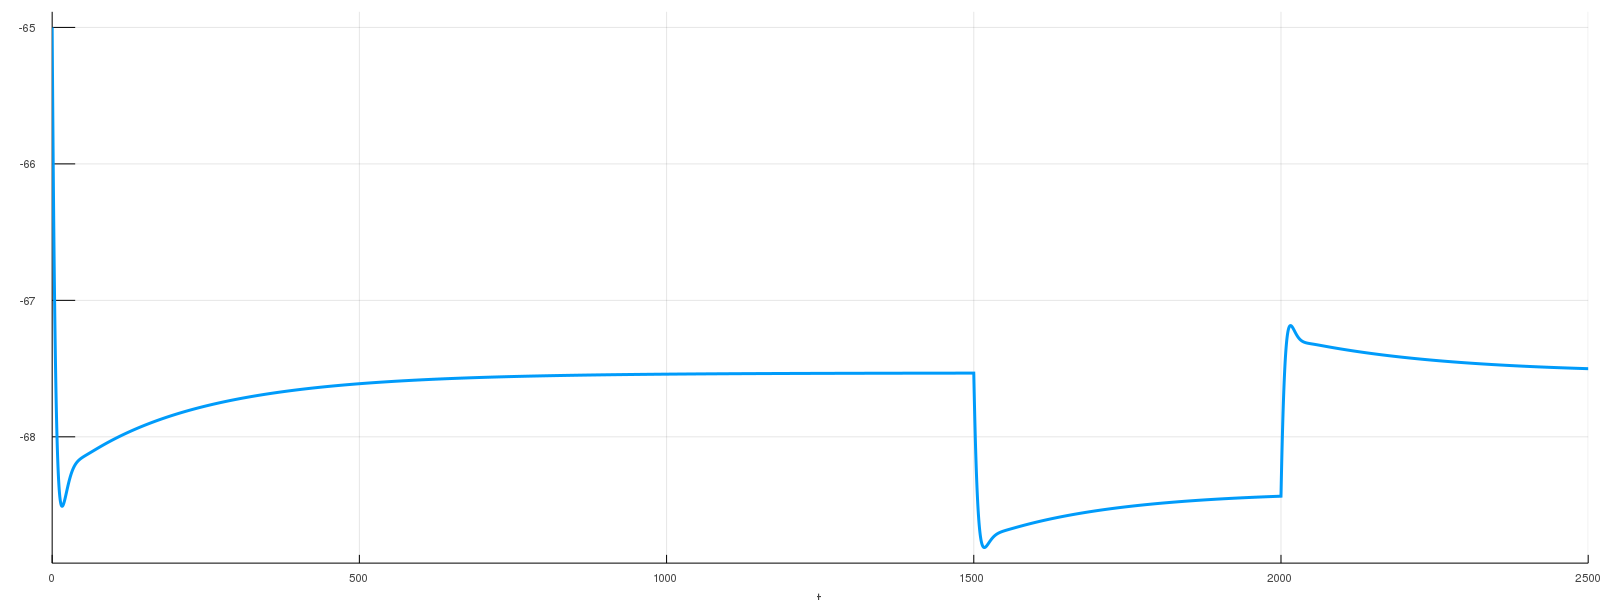

In [53]:
# running the simulation
_p = (E=(sodium=82.0, potassium=-81.0, ih=-46.0, leak=-65.0, syn=3.0), 
      stim=(start=1500, step=-0.2, holding=0, dur=500, noise=0),)

# ih.h.Vhalf = -60.0
# HHModel.update!(ih)

tspan = (0.0, 2500.0)
v0 = -60.9766
v0 = -65;
u0 = HHModel.setup_init(_model, v0)

prob = ODEProblem(_model_sim_cc, u0, tspan, _p)
@time sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

# preview voltage trace
plot(sol, vars=(1), legend=nothing)
# savefig("demo2.svg")

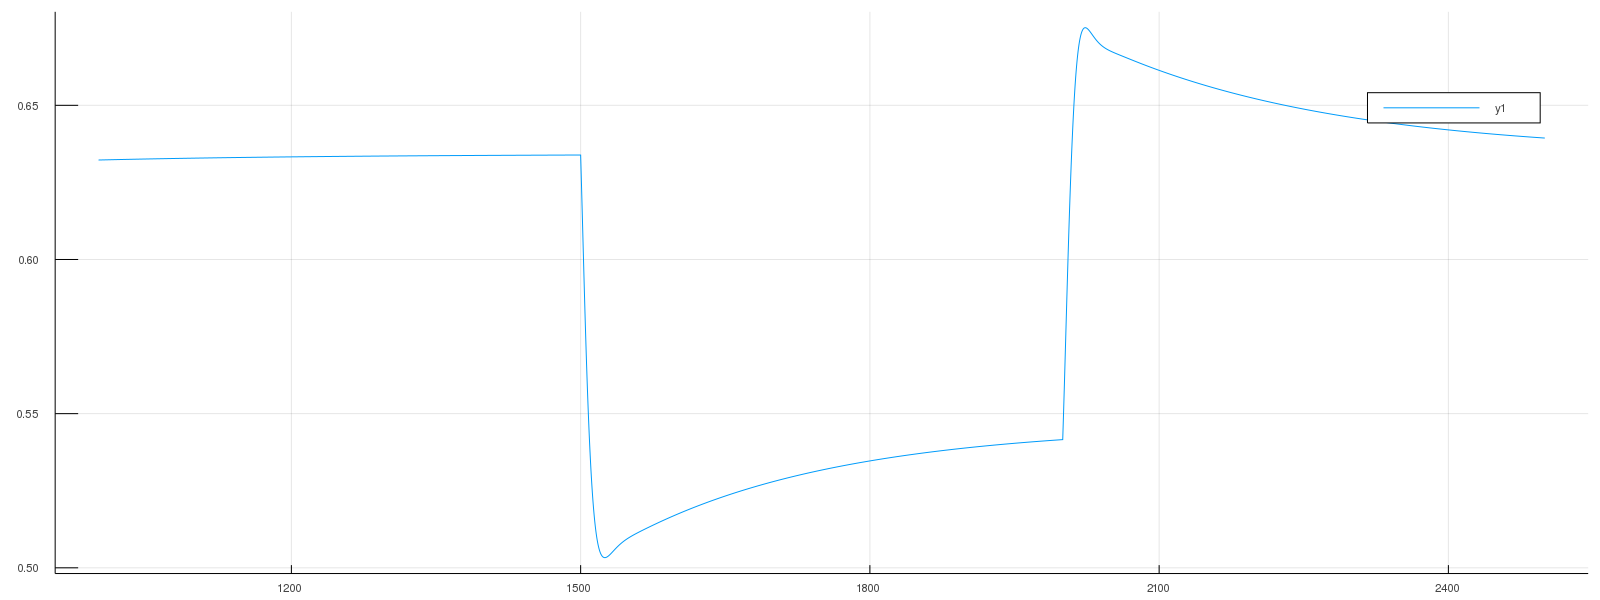

In [61]:
# preview current
_trange = 1000:0.1:2500
_trace = HHModel.current_decompose(sol, _model, _trange, _p);

plot(_trange, _trace.ltk)

---

In [ ]:
# preview dynamics

# dynamics between membrane potential and a particular kinetic variable
plot(sol, vars=(1,2), size=(500, 500), legend=nothing)

In [ ]:
_down_array

In [ ]:
# PCA projection
_var_array = hcat(sol(500:0.1:2000).u...)[2:end-1, :]

_down = fit(PCA, _var_array, );

_down_array = transform(_down, _var_array);

plot(_down_array[1,:], _down_array[2, :], size=(500, 500), legend=nothing)

---

In [ ]:
current_step_vec = (t, param) -> begin
    _ans = ones(size(t)) .* param.holding
    _ans[(param.start .< t) .& (t .< param.dur+param.start)] .+= param.step
    _ans
end

# sweep protocol
_sweep_protocol = [
    ("cc_ih_1_ikl_0_ih_0", 0, 0),
    ("cc_ih_1_ikl_0.35_ih_0", 0.35, 0),
    ("cc_ih_1_ikl_0.65_ih_0", 0.65, 0),
    ("cc_ih_1_ikl_1.1_ih_0", 1.1, 0),
    ("cc_ih_1_ikl_0_ih_0.01", 0, 0.01),
    ("cc_ih_1_ikl_0.35_ih_0.01", 0.35, 0.01),
    ("cc_ih_1_ikl_0.65_ih_0.01", 0.65, 0.01),
    ("cc_ih_1_ikl_1.1_ih_0.01", 1.1, 0),
    ("cc_ih_1_ikl_0_ih_0.1", 0, 0.1),
    ("cc_ih_1_ikl_0.35_ih_0.1", 0.35, 0.1),
    ("cc_ih_1_ikl_0.65_ih_0.1", 0.65, 0.1),
    ("cc_ih_1_ikl_1.1_ih_0.1", 1.1, 0.1),
    ("cc_ih_1_ikl_0_ih_0.5", 0, 0.5),
    ("cc_ih_1_ikl_0.35_ih_0.5", 0.35, 0.5),
    ("cc_ih_1_ikl_0.65_ih_0.5", 0.65, 0.5),
    ("cc_ih_1_ikl_1.1_ih_0.5", 1.1, 0.5),
    ("cc_ih_1_ikl_0_ih_0.9", 0, 0.9),
    ("cc_ih_1_ikl_0.35_ih_0.9", 0.35, 0.9),
    ("cc_ih_1_ikl_0.65_ih_0.9", 0.65, 0.9),
    ("cc_ih_1_ikl_1.1_ih_0.9", 1.1, 0.9),
]
_pbar = Progress(length(_sweep_protocol))
for _each in _sweep_protocol
_export_name = _each[1]
_current_steps = -1:0.2:1.0
_tspan = 1200:0.01:2500
_current = zeros((length(_tspan), length(_current_steps)))
_voltage = zeros(size(_current))

ltk.g = _each[2]
ih.g = _each[3]

plot(legend=nothing, ylim=(-150, 80), xlim=(190, 250))

for (_idx, _i_step) in enumerate(_current_steps)
    _p = (E=(sodium=81.27, potassium=-80.78, ih=-26, leak=-65, syn=3), 
      stim=(start=1400, step=_i_step, holding=0, dur=600, noise=0),)
    prob = ODEProblem(_model_sim_cc, u0, tspan, _p)
    sol = solve(prob, Tsit5(), dt=0.1)

    _current[:, _idx] = current_step_vec(_tspan, _p.stim) .* 10
    _voltage[:, _idx] = hcat(sol(_tspan)...)[1, :]
    
    plot!(sol, vars=(1), color=:black, alpha=0.3)
end

    HHModel.export_as_atf(_export_name*".atf", _tspan .- 1200, _current, _voltage)
    HHModel.export_as_hdf5(_export_name*".h5", _tspan, _current, _voltage)

# plot!(ylim=(-100, -50))
    next!(_pbar)
end

voltage clamp check out the `RCCircuit.ipynb`